# **TOTAL RUN**

### **First Part: exploration of optimizer and training dataset size**

In [7]:
import os, random, time, pickle
from pathlib import Path
from datetime import datetime

import numpy as np
import torch, torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.decomposition import PCA

# Reproducibility
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)


Device: cuda


First, let's load cifar datas.  
Note that, a function to take some fraction of the training data is also defined here.

In [8]:
# CIFAR‑10 transforms & datasets
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std  = (0.2023, 0.1994, 0.2010)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])

data_root = './data'
train_dataset_full = datasets.CIFAR10(root=data_root, train=True, download=True, transform=transform_train)
val_dataset_full   = datasets.CIFAR10(root=data_root, train=False, download=True, transform=transform_test)

val_loader_full    = DataLoader(val_dataset_full, batch_size=128, shuffle=False, num_workers=2)

# function for taking a subset of the training data
def get_subset_loader(dataset, subset_size, batch_size=64, shuffle=True, seed=42):
    if subset_size >= len(dataset):
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2)
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(dataset), subset_size, replace=False)
    subset = Subset(dataset, idx)
    return DataLoader(subset, batch_size=batch_size, shuffle=shuffle, num_workers=2)


Then, we define our CNN.  
This will be our main architecture. We will reuse this in the second part of the code, when searching for data augmentation.  

But right now, we experiment with it and with different optimizers.  
And we will perform loss landscape plots in 2D with PCA, with the trajectory of the weights uptades next to have some insight about the problem.  

In [9]:

class CIFAR10CNN(nn.Module):
    def __init__(self, dropout=0.25, dropout_classifier=0.5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(dropout),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(dropout),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(dropout),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*4*4, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_classifier),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


Define a function to call 3 different optimizers:  
-SGD  
-ADAM  
-LION

In [10]:

def build_optimizer(name, model):
    if name == 'sgd':
        return torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)
    if name == 'adam':
        return torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    if name == 'lion':
        from lion_pytorch import Lion
        return Lion(model.parameters(), lr=2e-4, weight_decay=5e-3)
    raise ValueError(name)


Let's define some function to get our model parameters as a vector.  
It will be useful for PCA loss landscape plots later.

In [11]:
def weights_to_vec(model):
    return torch.nn.utils.parameters_to_vector(model.parameters()).detach().cpu()

def vec_to_weights(model, vec):
    vec = vec.to(next(model.parameters()).device)
    torch.nn.utils.vector_to_parameters(vec, model.parameters())


In [12]:
# Here is our train loop for one epoch, and the eval function
# The last function is useful to calculate the loss, it will be used in the PCA loss landscape plots.

def train_one_epoch(epoch, train_load, model, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (images, targets) in enumerate(train_load):
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f'Epoch {epoch:03d}  Train Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}')
    return epoch_loss

@torch.no_grad()
def evaluate(model, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, targets in val_loader_full:
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)
        loss = criterion(outputs, targets)
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    loss = running_loss / total
    acc = correct / total
    return loss, acc


@torch.no_grad()
def compute_validation_loss(model, loader):
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    tot, n = 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        tot += loss_fn(model(x), y).item() * x.size(0)
        n += x.size(0)
    return tot / n


Now the big pca landscape plot function:  
-It performs a PCA  
-Then, It plots the loss variations along the two pricipal vector, making a nice loss landscape  
-Then, It adds the trajectories of the weights updates, projected in the 2D plae defined by the principal vectors  

In [14]:

def plot_pca_with_contours(model, loader, weights_history, out_path=None, steps=21, pad_ratio=0.15, cmap='viridis', levels=40):
    print('Computing PCA landscape ...')
    W = torch.stack(weights_history).numpy()   #stack the weight vectors, and perform the PCA on it. More detail in the Annexe of our report.
    pca = PCA(n_components=2).fit(W)
    traj_2d = pca.transform(W)

    x_min, x_max = traj_2d[:,0].min(), traj_2d[:,0].max()
    y_min, y_max = traj_2d[:,1].min(), traj_2d[:,1].max()
    dx, dy = x_max - x_min, y_max - y_min
    al = np.linspace(x_min - dx*pad_ratio, x_max + dx*pad_ratio, steps)   #use pad ratio to have our loss plot not sticked to the trajectory
    be = np.linspace(y_min - dy*pad_ratio, y_max + dy*pad_ratio, steps)

    w_star = torch.tensor(W[-1])
    d1, d2 = map(torch.tensor, pca.components_)   #the two principal vector
    loss_grid = np.zeros((steps, steps))          #the loss grid definition, the grid is of size (steps x steps)
    original = weights_to_vec(model)
    for i, a in enumerate(al):
        for j, b in enumerate(be):
            vec = w_star + a*d1 + b*d2
            vec_to_weights(model, vec)
            loss_grid[j,i] = compute_validation_loss(model, loader)
        print(f'    grid row {i+1}/{steps} done')

    vec_to_weights(model, original)
    fig, ax = plt.subplots(figsize=(5,4))
    cf = ax.contourf(al, be, loss_grid, levels=levels, cmap=cmap)
    ax.plot(traj_2d[:,0], traj_2d[:,1], 'w-o', lw=2, ms=4)
    fig.colorbar(cf, ax=ax, label='loss')
    ax.set_xlabel('PC-1'); ax.set_ylabel('PC-2')
    ax.set_title('Trajectory + loss contours')
    fig.tight_layout()

    if out_path is not None:
        fig.savefig(out_path, dpi=150)
    plt.show(); plt.close(fig)
    
    return {'alpha_vec': al, 'beta_vec': be, 'loss_grid': loss_grid, 'traj_2d': traj_2d}


**And finally, the main run experiment loop**  
When calling this function, the code will run the 3 optimizers, with 3 data training set size, and perform the PCA and calculate the loss curve.  
All the datas are then saved in some files, since it takes a lot of time to run (especially the PCA plots, since the computation of the loss on each points of the grid is very long).  


**/!\ FOR DEBUGGING PURPOSE :** we set NUM_EPOCH to 20, and GRID_SIZE_FOR_LOSS_LANDSCAPE to 5.  
But in the annex plot, the values used are:  
- NUM_EPOCH=100  
- GRID_SIZE_FOR_LOSS_LANDSCAPE=11  

But it takes some time...

In [18]:
# ********************************************************************
# VALUES TO CHANGE :                 ORIGINAL VALUES (used for report)
NUM_EPOCHS = 20                     # = 100
GRID_SIZE_FOR_LOSS_LANDSCAPE = 5    # = 11
# ********************************************************************

OPTIMIZERS = ['sgd', 'adam', 'lion']
SIZES = [168, 1_000, 20_000]
out_root = Path('results')

def run_experiment(opt_name, subset_size, seed=42):
    print(f'\n===== [START] {opt_name.upper()} | n={subset_size} =====')
    out_dir = out_root / opt_name / f'n_{subset_size}'
    out_dir.mkdir(parents=True, exist_ok=True)
    
    # Load a subset of the training data (defined in the first cells)
    train_loader = get_subset_loader(train_dataset_full, subset_size, batch_size=128, shuffle=True, seed=seed)
    seed_everything(seed)

    # model, optimizer, etc
    model = CIFAR10CNN().to(device)
    optimizer = build_optimizer(opt_name, model)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    criterion = nn.CrossEntropyLoss()

    # define the quantities that we will save for the plots later
    weights_history = [weights_to_vec(model)]
    train_losses, val_losses, val_acc = [], [], []
    best_acc = 0.0
    for epoch in range(1, NUM_EPOCHS+1):
        tl = train_one_epoch(epoch, train_loader, model, optimizer, criterion)
        vl, va = evaluate(model, criterion)
        scheduler.step(vl)
        train_losses.append(tl)
        val_losses.append(vl)
        val_acc.append(va)
        print(f'Epoch {epoch:03d} | Val Loss: {vl:.4f} | Acc: {va:.4f}')
        if va > best_acc:
            best_acc = va
            torch.save(model.state_dict(), out_dir / 'best_model.pth')
        weights_history.append(weights_to_vec(model))   # the weights vector are stored here
        print("")

    # plots
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(train_losses, label='train')
    ax.plot(val_losses, label='val')
    ax.set_xlabel('epoch'); ax.set_ylabel('loss'); ax.set_title('Loss curves') 
    ax.legend(); ax.grid(True)
    fig.tight_layout(); fig.savefig(out_dir / 'loss_curves.png', dpi=150)
    plt.show(); plt.close(fig)
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(val_acc, label='val acc')
    ax.set_xlabel('epoch'); ax.set_ylabel('accuracy'); ax.set_title('Accuracy curve')
    ax.legend(); ax.grid(True)
    fig.tight_layout(); fig.savefig(out_dir / 'accuracy_curve.png', dpi=150)
    plt.show(); plt.close(fig)

    # PCA plot (takes a long time !!!)
    pca_dict = plot_pca_with_contours(model, val_loader_full, weights_history, out_path=out_dir/'pca_contour.png', steps=GRID_SIZE_FOR_LOSS_LANDSCAPE, pad_ratio=0.2)

    # save torch dict
    torch.save({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_acc': val_acc,
        'weights_history': weights_history,
        **pca_dict,
    }, out_dir / 'results.pt')
    print(f'===== [DONE] {opt_name.upper()} | n={subset_size} =====')



===== [START] SGD | n=168 =====
Epoch 001  Train Loss: 2.4182  Acc: 0.1190
Epoch 001 | Val Loss: 2.3155 | Acc: 0.1105

Epoch 002  Train Loss: 5.2315  Acc: 0.1607
Epoch 002 | Val Loss: 2.6219 | Acc: 0.1000

Epoch 003  Train Loss: 2.5370  Acc: 0.1190
Epoch 003 | Val Loss: 2.6831 | Acc: 0.1518

Epoch 004  Train Loss: 2.2585  Acc: 0.1369
Epoch 004 | Val Loss: 4.0564 | Acc: 0.1141

Epoch 005  Train Loss: 2.2943  Acc: 0.1548
Epoch 005 | Val Loss: 4.8708 | Acc: 0.1523

Epoch 006  Train Loss: 2.2862  Acc: 0.1012
Epoch 006 | Val Loss: 3.3012 | Acc: 0.1659

Epoch 007  Train Loss: 2.2353  Acc: 0.1369
Epoch 007 | Val Loss: 3.2224 | Acc: 0.1795

Epoch 008  Train Loss: 2.1223  Acc: 0.2202
Epoch 008 | Val Loss: 3.0298 | Acc: 0.1847

Epoch 009  Train Loss: 2.1052  Acc: 0.2381
Epoch 009 | Val Loss: 2.6549 | Acc: 0.1801

Epoch 010  Train Loss: 2.1392  Acc: 0.1667
Epoch 010 | Val Loss: 2.5108 | Acc: 0.1795

Epoch 011  Train Loss: 2.1029  Acc: 0.1964
Epoch 011 | Val Loss: 2.3964 | Acc: 0.1961

Epoch 012 

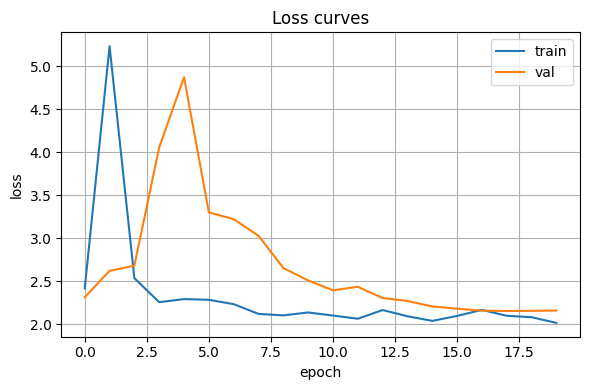

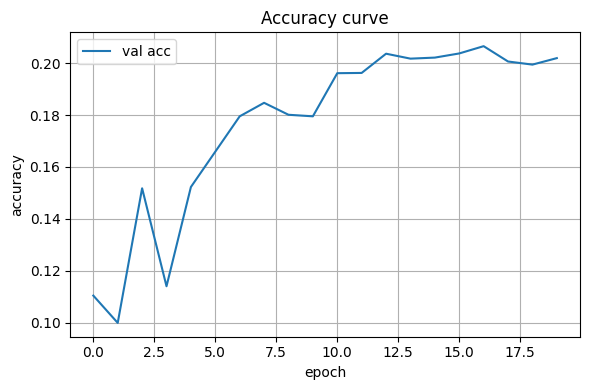

Computing PCA landscape ...
    grid row 1/5 done
    grid row 2/5 done
    grid row 3/5 done
    grid row 4/5 done
    grid row 5/5 done


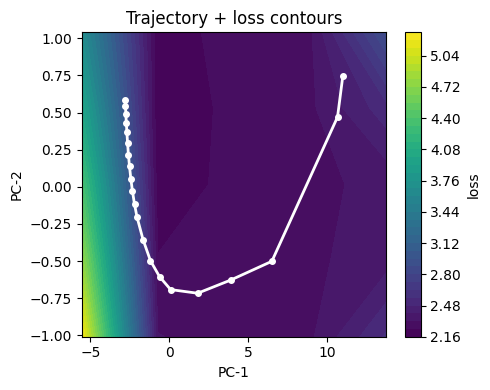

===== [DONE] SGD | n=168 =====

===== [START] SGD | n=1000 =====
Epoch 001  Train Loss: 2.9534  Acc: 0.1090
Epoch 001 | Val Loss: 2.3150 | Acc: 0.1085

Epoch 002  Train Loss: 2.3080  Acc: 0.1330
Epoch 002 | Val Loss: 2.4225 | Acc: 0.1223

Epoch 003  Train Loss: 2.2730  Acc: 0.1380
Epoch 003 | Val Loss: 2.1742 | Acc: 0.1613

Epoch 004  Train Loss: 2.1885  Acc: 0.1640
Epoch 004 | Val Loss: 2.1179 | Acc: 0.1517

Epoch 005  Train Loss: 2.1333  Acc: 0.1940
Epoch 005 | Val Loss: 2.3805 | Acc: 0.1348

Epoch 006  Train Loss: 2.1597  Acc: 0.1580
Epoch 006 | Val Loss: 1.9940 | Acc: 0.2264

Epoch 007  Train Loss: 2.1314  Acc: 0.2150
Epoch 007 | Val Loss: 2.0411 | Acc: 0.2505

Epoch 008  Train Loss: 2.1379  Acc: 0.1890
Epoch 008 | Val Loss: 2.0165 | Acc: 0.2181

Epoch 009  Train Loss: 2.1256  Acc: 0.1790
Epoch 009 | Val Loss: 2.1437 | Acc: 0.1614

Epoch 010  Train Loss: 2.1017  Acc: 0.1820
Epoch 010 | Val Loss: 2.1911 | Acc: 0.1344

Epoch 011  Train Loss: 2.1464  Acc: 0.1720
Epoch 011 | Val Loss: 

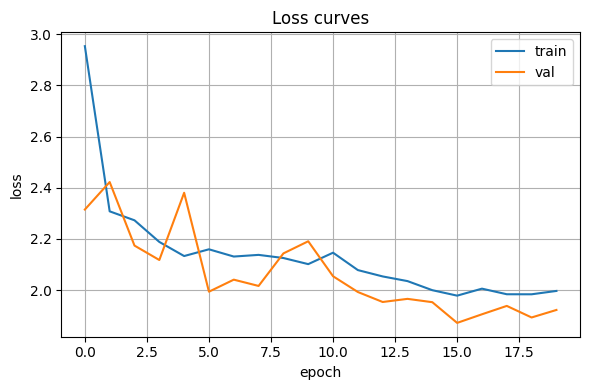

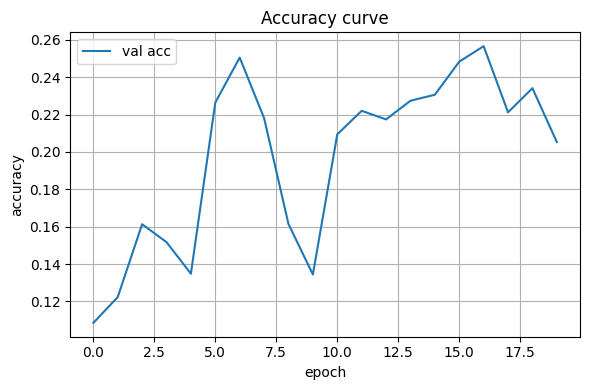

Computing PCA landscape ...
    grid row 1/5 done
    grid row 2/5 done
    grid row 3/5 done
    grid row 4/5 done
    grid row 5/5 done


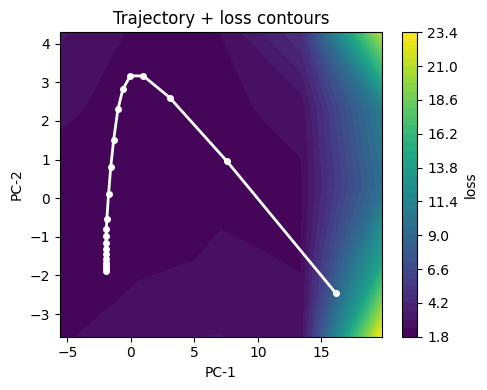

===== [DONE] SGD | n=1000 =====

===== [START] SGD | n=20000 =====
Epoch 001  Train Loss: 2.1482  Acc: 0.1705
Epoch 001 | Val Loss: 2.0227 | Acc: 0.1930

Epoch 002  Train Loss: 2.0312  Acc: 0.1930
Epoch 002 | Val Loss: 1.8366 | Acc: 0.2594

Epoch 003  Train Loss: 1.9150  Acc: 0.2376
Epoch 003 | Val Loss: 2.0820 | Acc: 0.2122

Epoch 004  Train Loss: 1.8279  Acc: 0.2753
Epoch 004 | Val Loss: 1.7085 | Acc: 0.3338

Epoch 005  Train Loss: 1.7152  Acc: 0.3317
Epoch 005 | Val Loss: 1.7526 | Acc: 0.3512

Epoch 006  Train Loss: 1.5911  Acc: 0.4016
Epoch 006 | Val Loss: 1.4292 | Acc: 0.4650

Epoch 007  Train Loss: 1.4853  Acc: 0.4576
Epoch 007 | Val Loss: 1.3731 | Acc: 0.5028

Epoch 008  Train Loss: 1.3858  Acc: 0.4986
Epoch 008 | Val Loss: 2.2079 | Acc: 0.3798

Epoch 009  Train Loss: 1.3129  Acc: 0.5313
Epoch 009 | Val Loss: 1.5363 | Acc: 0.4997

Epoch 010  Train Loss: 1.2544  Acc: 0.5560
Epoch 010 | Val Loss: 1.2736 | Acc: 0.5424

Epoch 011  Train Loss: 1.2015  Acc: 0.5743
Epoch 011 | Val Loss

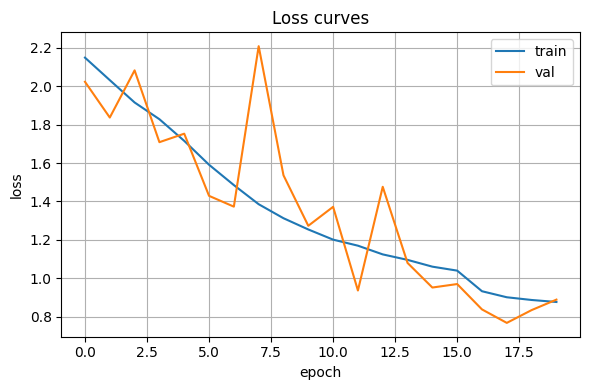

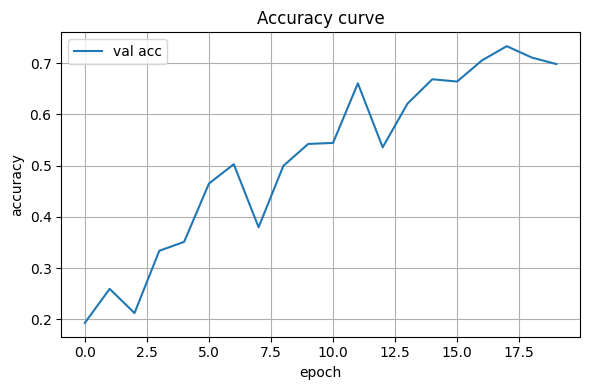

Computing PCA landscape ...
    grid row 1/5 done
    grid row 2/5 done
    grid row 3/5 done
    grid row 4/5 done
    grid row 5/5 done


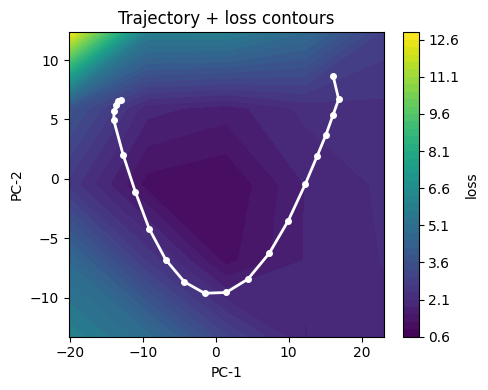

===== [DONE] SGD | n=20000 =====

===== [START] ADAM | n=168 =====
Epoch 001  Train Loss: 2.4171  Acc: 0.1071
Epoch 001 | Val Loss: 2.3017 | Acc: 0.1000

Epoch 002  Train Loss: 2.6066  Acc: 0.1310
Epoch 002 | Val Loss: 2.2988 | Acc: 0.1086

Epoch 003  Train Loss: 2.3873  Acc: 0.1726
Epoch 003 | Val Loss: 2.2944 | Acc: 0.1071

Epoch 004  Train Loss: 2.2965  Acc: 0.1726
Epoch 004 | Val Loss: 2.2803 | Acc: 0.1530

Epoch 005  Train Loss: 2.1715  Acc: 0.2024
Epoch 005 | Val Loss: 2.2536 | Acc: 0.1642

Epoch 006  Train Loss: 2.0954  Acc: 0.2202
Epoch 006 | Val Loss: 2.2239 | Acc: 0.1727

Epoch 007  Train Loss: 2.0006  Acc: 0.2500
Epoch 007 | Val Loss: 2.1957 | Acc: 0.1658

Epoch 008  Train Loss: 1.9841  Acc: 0.2619
Epoch 008 | Val Loss: 2.1680 | Acc: 0.1761

Epoch 009  Train Loss: 1.9555  Acc: 0.2976
Epoch 009 | Val Loss: 2.1492 | Acc: 0.1940

Epoch 010  Train Loss: 1.9271  Acc: 0.2976
Epoch 010 | Val Loss: 2.1357 | Acc: 0.2069

Epoch 011  Train Loss: 1.8835  Acc: 0.3095
Epoch 011 | Val Loss

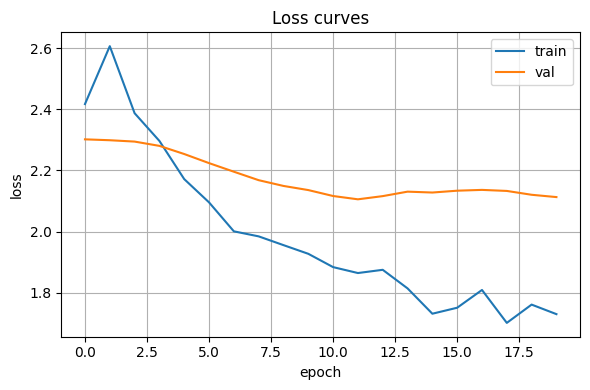

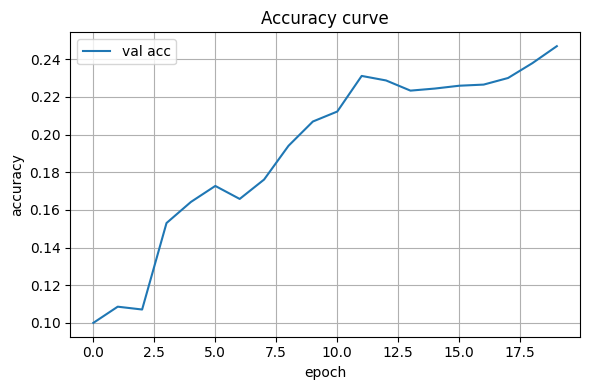

Computing PCA landscape ...
    grid row 1/5 done
    grid row 2/5 done
    grid row 3/5 done
    grid row 4/5 done
    grid row 5/5 done


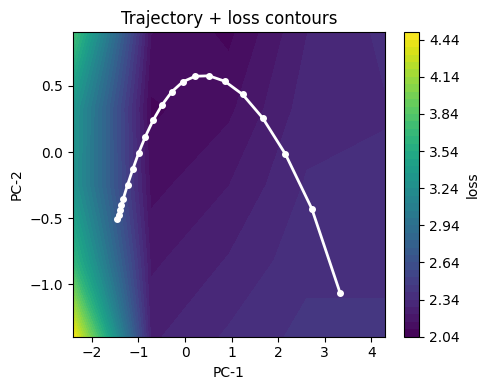

===== [DONE] ADAM | n=168 =====

===== [START] ADAM | n=1000 =====
Epoch 001  Train Loss: 2.4970  Acc: 0.1150
Epoch 001 | Val Loss: 2.2845 | Acc: 0.1446

Epoch 002  Train Loss: 2.1337  Acc: 0.2110
Epoch 002 | Val Loss: 2.1723 | Acc: 0.1942

Epoch 003  Train Loss: 2.0060  Acc: 0.2570
Epoch 003 | Val Loss: 2.1015 | Acc: 0.2084

Epoch 004  Train Loss: 1.9100  Acc: 0.2910
Epoch 004 | Val Loss: 1.9739 | Acc: 0.2419

Epoch 005  Train Loss: 1.8545  Acc: 0.2930
Epoch 005 | Val Loss: 1.8831 | Acc: 0.2691

Epoch 006  Train Loss: 1.8417  Acc: 0.2960
Epoch 006 | Val Loss: 1.8061 | Acc: 0.3321

Epoch 007  Train Loss: 1.7608  Acc: 0.3320
Epoch 007 | Val Loss: 1.7901 | Acc: 0.3309

Epoch 008  Train Loss: 1.6957  Acc: 0.3740
Epoch 008 | Val Loss: 1.7282 | Acc: 0.3468

Epoch 009  Train Loss: 1.6696  Acc: 0.3560
Epoch 009 | Val Loss: 1.6674 | Acc: 0.3794

Epoch 010  Train Loss: 1.6360  Acc: 0.3590
Epoch 010 | Val Loss: 1.6090 | Acc: 0.3973

Epoch 011  Train Loss: 1.6064  Acc: 0.3900
Epoch 011 | Val Loss

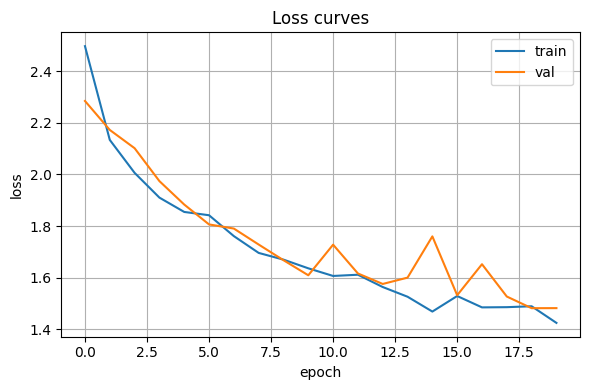

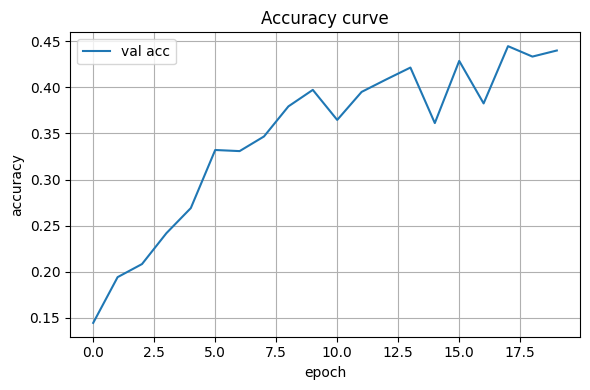

Computing PCA landscape ...
    grid row 1/5 done
    grid row 2/5 done
    grid row 3/5 done
    grid row 4/5 done
    grid row 5/5 done


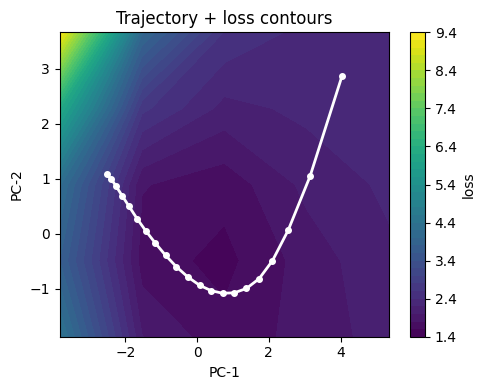

===== [DONE] ADAM | n=1000 =====

===== [START] ADAM | n=20000 =====
Epoch 001  Train Loss: 1.8771  Acc: 0.2918
Epoch 001 | Val Loss: 1.4840 | Acc: 0.4332

Epoch 002  Train Loss: 1.5894  Acc: 0.4063
Epoch 002 | Val Loss: 1.3418 | Acc: 0.4889

Epoch 003  Train Loss: 1.4504  Acc: 0.4638
Epoch 003 | Val Loss: 1.3452 | Acc: 0.5065

Epoch 004  Train Loss: 1.3415  Acc: 0.5157
Epoch 004 | Val Loss: 1.1779 | Acc: 0.5684

Epoch 005  Train Loss: 1.2675  Acc: 0.5466
Epoch 005 | Val Loss: 1.0397 | Acc: 0.6231

Epoch 006  Train Loss: 1.2006  Acc: 0.5682
Epoch 006 | Val Loss: 1.0926 | Acc: 0.6018

Epoch 007  Train Loss: 1.1719  Acc: 0.5836
Epoch 007 | Val Loss: 1.0701 | Acc: 0.6348

Epoch 008  Train Loss: 1.1233  Acc: 0.6058
Epoch 008 | Val Loss: 0.9430 | Acc: 0.6585

Epoch 009  Train Loss: 1.0848  Acc: 0.6161
Epoch 009 | Val Loss: 0.9099 | Acc: 0.6707

Epoch 010  Train Loss: 1.0579  Acc: 0.6220
Epoch 010 | Val Loss: 0.8704 | Acc: 0.6800

Epoch 011  Train Loss: 1.0402  Acc: 0.6362
Epoch 011 | Val Lo

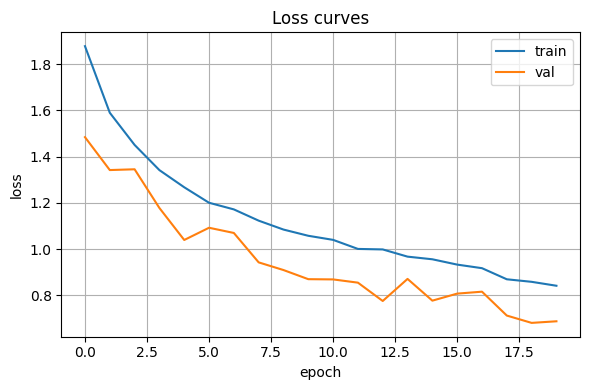

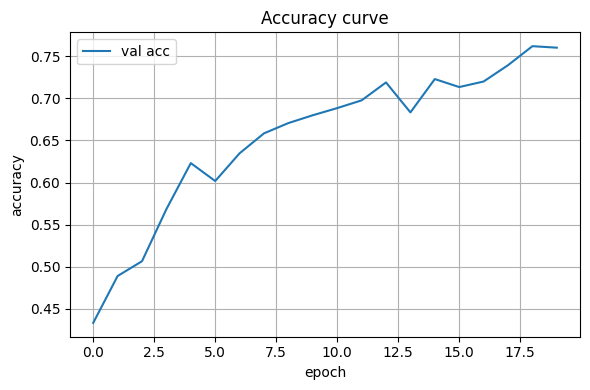

Computing PCA landscape ...
    grid row 1/5 done
    grid row 2/5 done
    grid row 3/5 done
    grid row 4/5 done
    grid row 5/5 done


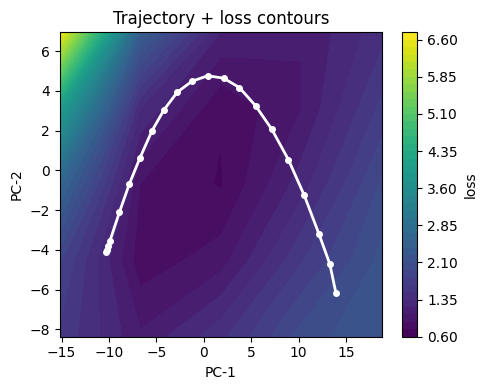

===== [DONE] ADAM | n=20000 =====

===== [START] LION | n=168 =====
Epoch 001  Train Loss: 2.3726  Acc: 0.1071
Epoch 001 | Val Loss: 2.3027 | Acc: 0.1000

Epoch 002  Train Loss: 2.3143  Acc: 0.1131
Epoch 002 | Val Loss: 2.3026 | Acc: 0.1000

Epoch 003  Train Loss: 2.3008  Acc: 0.1310
Epoch 003 | Val Loss: 2.3024 | Acc: 0.1000

Epoch 004  Train Loss: 2.2607  Acc: 0.1607
Epoch 004 | Val Loss: 2.3020 | Acc: 0.1001

Epoch 005  Train Loss: 2.2929  Acc: 0.1131
Epoch 005 | Val Loss: 2.3008 | Acc: 0.1107

Epoch 006  Train Loss: 2.2454  Acc: 0.2024
Epoch 006 | Val Loss: 2.2992 | Acc: 0.1242

Epoch 007  Train Loss: 2.1579  Acc: 0.2143
Epoch 007 | Val Loss: 2.2926 | Acc: 0.1351

Epoch 008  Train Loss: 2.1538  Acc: 0.2381
Epoch 008 | Val Loss: 2.2872 | Acc: 0.1374

Epoch 009  Train Loss: 2.1390  Acc: 0.2381
Epoch 009 | Val Loss: 2.2764 | Acc: 0.1387

Epoch 010  Train Loss: 2.0464  Acc: 0.2500
Epoch 010 | Val Loss: 2.2588 | Acc: 0.1338

Epoch 011  Train Loss: 2.0501  Acc: 0.2560
Epoch 011 | Val Los

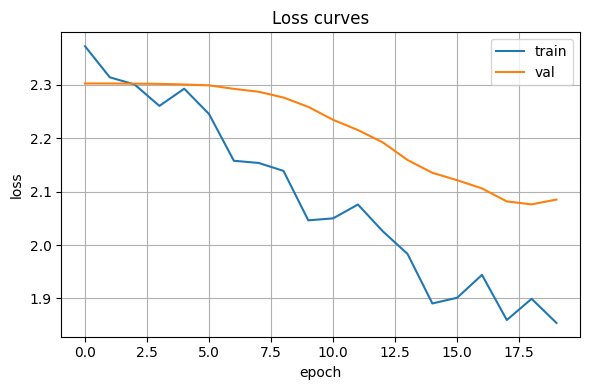

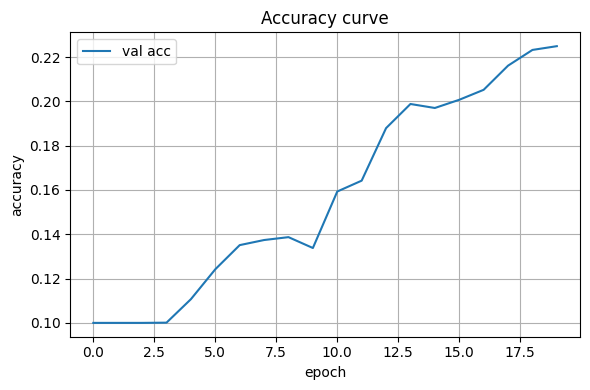

Computing PCA landscape ...
    grid row 1/5 done
    grid row 2/5 done
    grid row 3/5 done
    grid row 4/5 done
    grid row 5/5 done


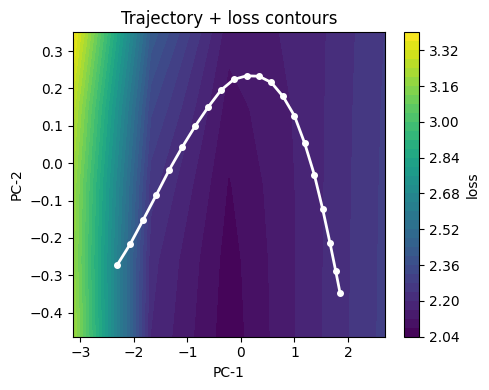

===== [DONE] LION | n=168 =====

===== [START] LION | n=1000 =====
Epoch 001  Train Loss: 2.3476  Acc: 0.1200
Epoch 001 | Val Loss: 2.3012 | Acc: 0.1187

Epoch 002  Train Loss: 2.2252  Acc: 0.1770
Epoch 002 | Val Loss: 2.2805 | Acc: 0.1583

Epoch 003  Train Loss: 2.0922  Acc: 0.2370
Epoch 003 | Val Loss: 2.1881 | Acc: 0.1769

Epoch 004  Train Loss: 2.0216  Acc: 0.2370
Epoch 004 | Val Loss: 2.0568 | Acc: 0.2257

Epoch 005  Train Loss: 1.9154  Acc: 0.2770
Epoch 005 | Val Loss: 1.9141 | Acc: 0.2990

Epoch 006  Train Loss: 1.8757  Acc: 0.2920
Epoch 006 | Val Loss: 1.8129 | Acc: 0.3324

Epoch 007  Train Loss: 1.7951  Acc: 0.3210
Epoch 007 | Val Loss: 1.7247 | Acc: 0.3667

Epoch 008  Train Loss: 1.7234  Acc: 0.3420
Epoch 008 | Val Loss: 1.6957 | Acc: 0.3621

Epoch 009  Train Loss: 1.7023  Acc: 0.3600
Epoch 009 | Val Loss: 1.6672 | Acc: 0.3738

Epoch 010  Train Loss: 1.6854  Acc: 0.3650
Epoch 010 | Val Loss: 1.6380 | Acc: 0.3905

Epoch 011  Train Loss: 1.6238  Acc: 0.3850
Epoch 011 | Val Loss

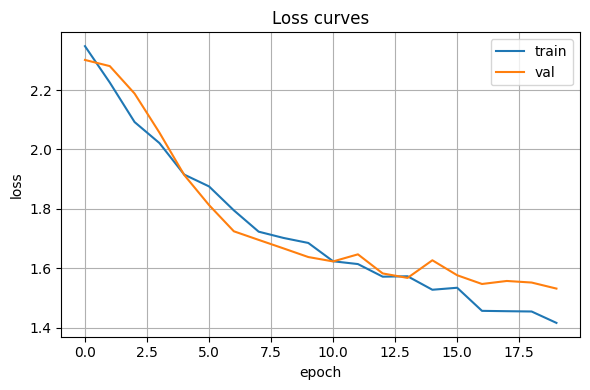

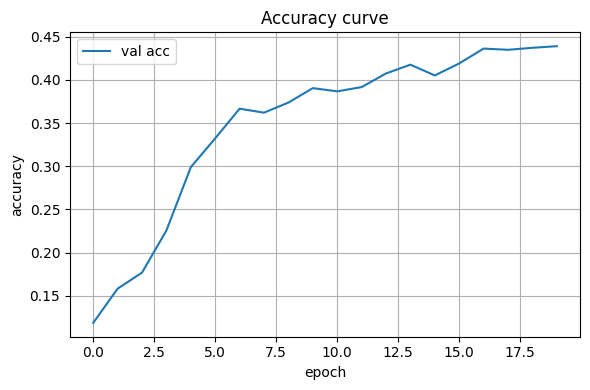

Computing PCA landscape ...
    grid row 1/5 done
    grid row 2/5 done
    grid row 3/5 done
    grid row 4/5 done
    grid row 5/5 done


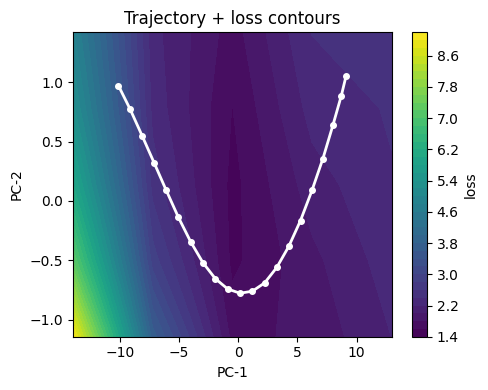

===== [DONE] LION | n=1000 =====

===== [START] LION | n=20000 =====
Epoch 001  Train Loss: 1.8680  Acc: 0.2938
Epoch 001 | Val Loss: 1.5044 | Acc: 0.4428

Epoch 002  Train Loss: 1.5690  Acc: 0.4164
Epoch 002 | Val Loss: 1.3255 | Acc: 0.5079

Epoch 003  Train Loss: 1.4566  Acc: 0.4662
Epoch 003 | Val Loss: 1.2263 | Acc: 0.5464

Epoch 004  Train Loss: 1.3583  Acc: 0.5098
Epoch 004 | Val Loss: 1.1198 | Acc: 0.5926

Epoch 005  Train Loss: 1.2819  Acc: 0.5417
Epoch 005 | Val Loss: 1.0585 | Acc: 0.6193

Epoch 006  Train Loss: 1.2161  Acc: 0.5590
Epoch 006 | Val Loss: 0.9983 | Acc: 0.6388

Epoch 007  Train Loss: 1.1658  Acc: 0.5863
Epoch 007 | Val Loss: 0.9785 | Acc: 0.6501

Epoch 008  Train Loss: 1.1285  Acc: 0.5991
Epoch 008 | Val Loss: 0.8991 | Acc: 0.6720

Epoch 009  Train Loss: 1.0927  Acc: 0.6121
Epoch 009 | Val Loss: 0.8911 | Acc: 0.6773

Epoch 010  Train Loss: 1.0489  Acc: 0.6282
Epoch 010 | Val Loss: 0.8627 | Acc: 0.6873

Epoch 011  Train Loss: 1.0241  Acc: 0.6416
Epoch 011 | Val Lo

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000002818AAF7E20>
Traceback (most recent call last):
  File "c:\Users\herma\anaconda3\envs\ML_optim\Lib\site-packages\torch\utils\data\dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "c:\Users\herma\anaconda3\envs\ML_optim\Lib\site-packages\torch\utils\data\dataloader.py", line 1621, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


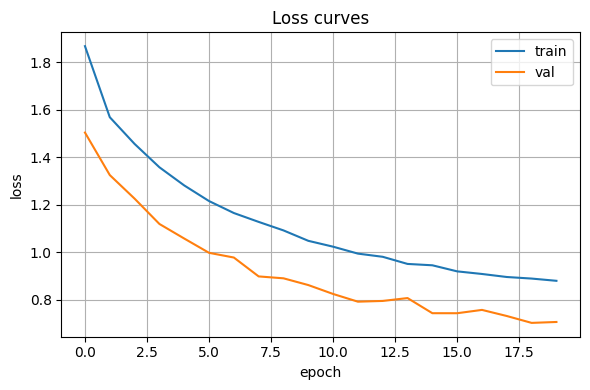

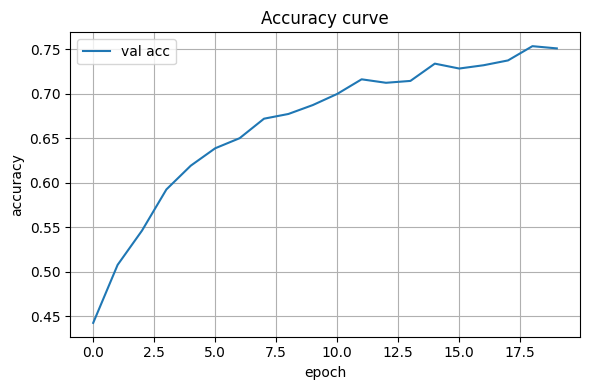

Computing PCA landscape ...
    grid row 1/5 done
    grid row 2/5 done
    grid row 3/5 done
    grid row 4/5 done
    grid row 5/5 done


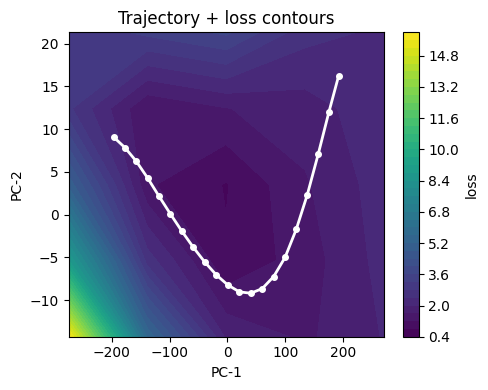

===== [DONE] LION | n=20000 =====


In [20]:
# /!\ CAREFUL /!\ -> Long‑running cell: launches the full 3×3 sweep
for opt in OPTIMIZERS:
    for size in SIZES:
        run_experiment(opt, size)

### **Loss/accuracy plots & PCA landscape plot**

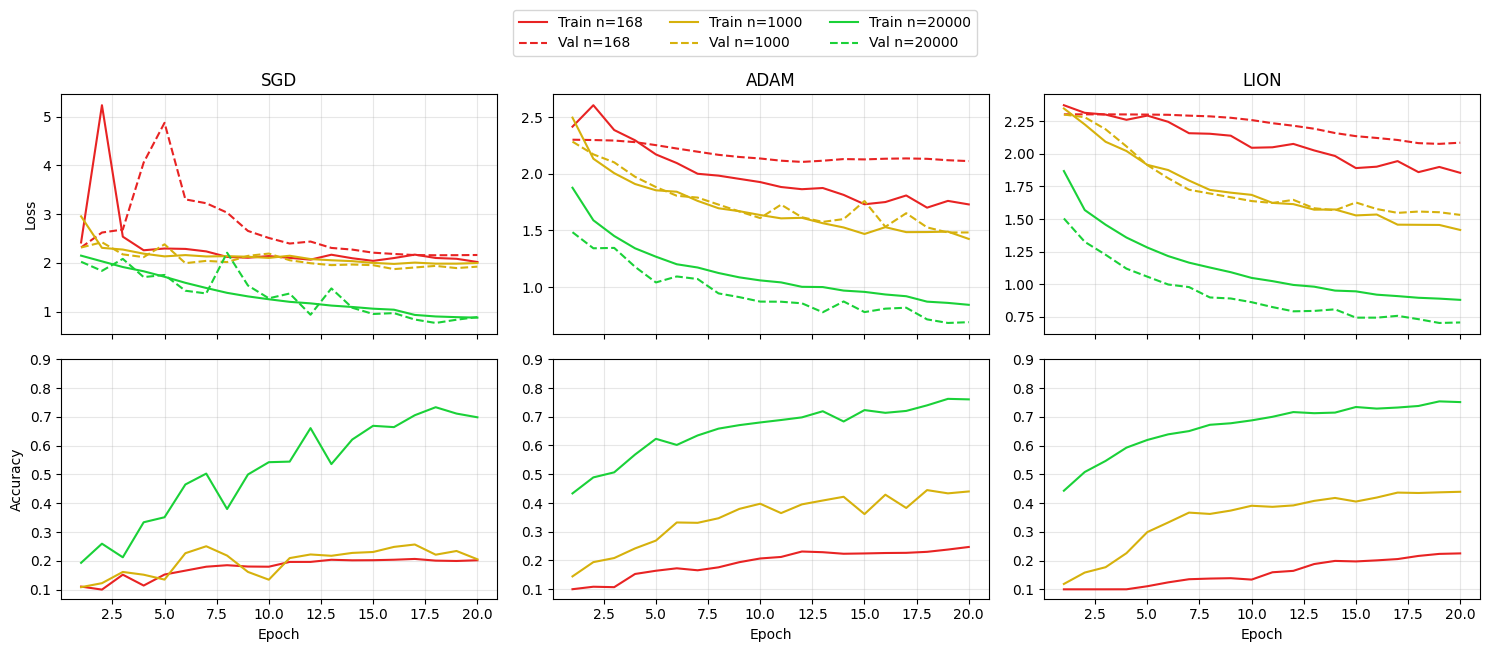

In [21]:
# =====================================================
#   Figure 1 – Loss & Accuracy · 3 opt · 3 tailles  
# =====================================================  
                       
import matplotlib.pyplot as plt
import torch, numpy as np
from pathlib import Path

optims = ['sgd', 'adam', 'lion']
sizes  = [168, 1000, 20000]
root   = Path('results')
#colors = ['tab:blue', 'tab:orange', 'tab:green']  
#colors = ['#4C72B0', '#DD8452', '#55A868']  
colors = [ "#e82323", "#d6b10c",  "#1ad138"]  


fig, axes = plt.subplots(2, 3, figsize=(15, 6), sharex='col', tight_layout=False)

for j, opt in enumerate(optims):
    for k, n in enumerate(sizes):
        p = root / opt / f'n_{n}' / 'results.pt'
        if not p.exists(): continue
        d = torch.load(p, map_location='cpu', weights_only=False)
        x = np.arange(1, len(d['train_losses']) + 1)

        # --- ligne 0 : loss -------------------------------------------------
        axes[0, j].plot(x, d['train_losses'], color=colors[k], label=f'Train n={n}')
        axes[0, j].plot(x, d['val_losses'],  color=colors[k], ls='--', label=f'Val n={n}')

        # --- ligne 1 : accuracy --------------------------------------------
        axes[1, j].plot(x, d['val_acc'], color=colors[k], label=f'n={n}')
        axes[1, j].set_yticks(np.linspace(0.1, 0.9, 9))

    axes[0, j].set_title(opt.upper(), pad=6)
    axes[1, j].set_xlabel('Epoch')
    axes[0, j].set_ylabel('Loss'     if j == 0 else '')
    axes[1, j].set_ylabel('Accuracy' if j == 0 else '')
    for a in axes[:, j]:
        a.grid(alpha=.3)

# légende unique centrée sous la 1e ligne
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1.09))
fig.subplots_adjust(wspace=0.25, hspace=0.15, top=0.90)
plt.savefig("loss_accuracy.pdf", format='pdf', bbox_inches='tight')
plt.show()


For the loss landscape plots, to compare fairly the algorithm between them and better see their "flatness", we use `contourf` plots.  
Indeed, some loss landscape have very hight peaks in the corners, that distort the colorbar and make them appears flat.  
Thus, we use `contourf`, and we plot 20 contourlines for the variations of loss:
- $\big[\min(\mathcal{L}), \ \min(\mathcal{L})+ \varepsilon\big] \quad$ 
With $\varepsilon=1$

Thus, we can see clearly that flatter minima will have lare blue zone, and narrower minima have a more condensed zone with all the veridis colormap in it, with white around that represent the loss values exceeding the bound of $\min(\mathcal{L})+1$  

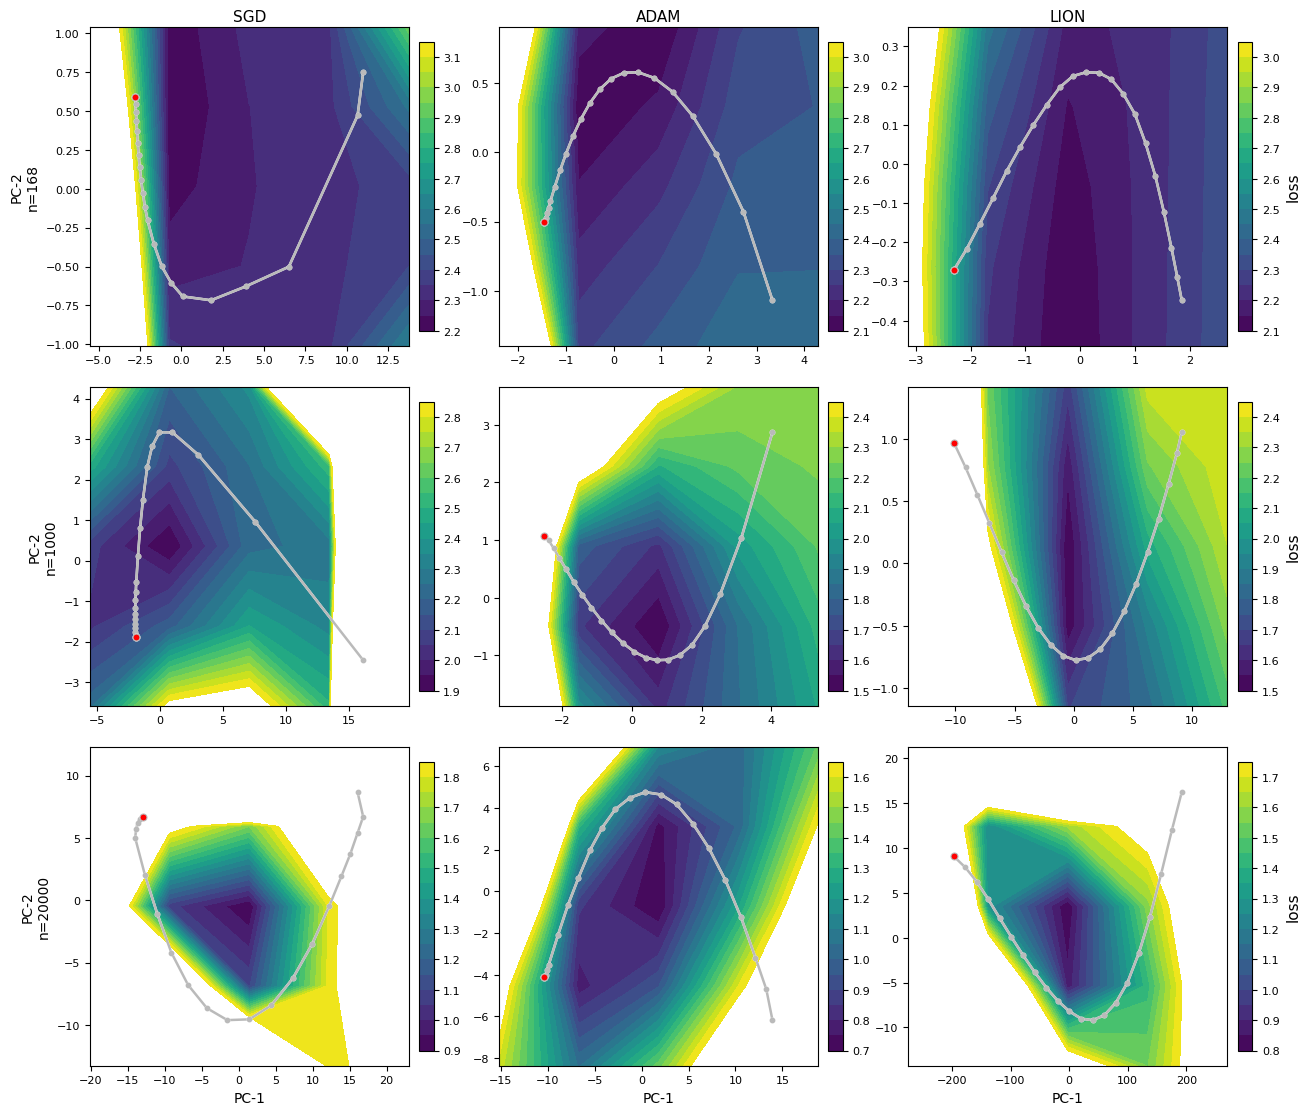

In [22]:
# =============================================================================
#   Figure 2 – Contours PCA + trajectoire (3 opt × 3 tailles)              
# =============================================================================

import matplotlib.pyplot as plt, torch
import numpy as np
from pathlib import Path
from matplotlib.ticker import FormatStrFormatter

optims = ['sgd', 'adam', 'lion']
sizes  = [168, 1000, 20000]
root   = Path('results')

# Mettre LOG = True si on souhaite mettre une échelle logharithmique pour mieux distinguer le landscape (les pics de hautes valeurs peuvent empêcher de bien voir la zone du minimum)
# Mettre CONTOUR = False pour désactiver le contour restreint à une certaine vartiation du loss \in [min(loss), min(loss) + epsilon]
LOG=False
CONTOUR=True

fig, axes = plt.subplots(3, 3, figsize=(15, 14))  
wspace, hspace = 0.19, 0.005                       
fig.subplots_adjust(wspace=wspace, hspace=hspace)


for i, n in enumerate(sizes):
    for j, opt in enumerate(optims):
        ax = axes[i, j]
        f  = root / opt / f'n_{n}' / 'results.pt'
        if not f.exists():
            ax.text(0.5, .5, 'missing', ha='center', va='center')
            ax.set_xticks([]); ax.set_yticks([])
            continue

        d      = torch.load(f, map_location='cpu', weights_only=False)
        al, be = d['alpha_vec'], d['beta_vec']
        grid   = d['loss_grid']
        traj   = d['traj_2d']

        # ----- contours ----------------------------------------------------
        maxrange=0.09
        if CONTOUR:
            cf = ax.contourf(al, be, grid, levels=(np.min(grid) + np.arange(0, 1, 0.05)), cmap='viridis')
        else:
            cf     = ax.contourf(al, be,        grid , 60, cmap='viridis')
            if LOG:
                cf = ax.contourf(al, be, np.log(grid), 50, cmap='viridis')
        # ----- trajectoire -------------------------------------------------
        ax.plot(traj[:, 0], traj[:, 1], color='white', lw=1.8)             # ligne
        ax.scatter(traj[:-1, 0], traj[:-1, 1], s=10, c='white', zorder=3)  # points blancs
        ax.scatter(traj[-1, 0],  traj[-1, 1], s=25, c='red',  edgecolors='white',
                   linewidths=0.8, zorder=4)                               # dernier point
        if CONTOUR:
            col="#BABABA"
            ax.plot(traj[:, 0], traj[:, 1], color=col, lw=1.8)             # ligne
            ax.scatter(traj[:-1, 0], traj[:-1, 1], s=10, c=col, zorder=3)  # points blancs
            ax.scatter(traj[-1, 0],  traj[-1, 1], s=25, c='red',  edgecolors=col,
                   linewidths=0.8, zorder=4)  
            #ax.scatter(traj[0, 0],  traj[0, 1], s=25, c='blue',  edgecolors='k',
            #       linewidths=0.8, zorder=4)   

        #square fig
        #ax.set_aspect('equal')
        ax.set_box_aspect(1)  # <-- Square tile shape
        # axes + labels
        if i==2:
            ax.set_xlabel('PC-1')
        #ax.set_ylabel('PC-2')
        ax.tick_params(labelsize=8)
        if i == 0:
            ax.set_title(opt.upper(), fontsize=11, pad=4)
        if j == 0:
            ax.set_ylabel(f'PC-2\nn={n}', fontsize=10)

        # petite colorbar individuelle collée au subplot
        #plt.colorbar(cf, ax=ax, fraction=0.035, pad=0.03, ticks=[]).set_label('loss', fontsize=8)
        if CONTOUR:
            cbar = plt.colorbar(cf, ax=ax, fraction=0.042, pad=0.03) #, ticks=np.linspace(np.min(grid), maxrange, 5))
        else:
            if LOG:
                cbar = plt.colorbar(cf, ax=ax, fraction=0.042, pad=0.03, ticks=np.linspace(np.min(np.log(grid)), np.max(np.log(grid)), 5))
            else :
                cbar = plt.colorbar(cf, ax=ax, fraction=0.042, pad=0.03, ticks=np.linspace(np.min(grid), np.max(grid), 5))
        if j == 2:
            if LOG:
                cbar.set_label('log(loss)', fontsize=11)
            else:
                cbar.set_label('loss', fontsize=11)
        cbar.ax.tick_params(labelsize=8)  # Set smaller tick label font size
        cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # <-- 1 decimal place

if CONTOUR:
    plt.savefig("total_pca_fig_contour.pdf", format='pdf', bbox_inches='tight')
else:
    if LOG:
        plt.savefig("total_pca_fig_log.pdf", format='pdf', bbox_inches='tight')
    else:
        plt.savefig("total_pca_fig.pdf", format='pdf', bbox_inches='tight')
plt.show()


### **Second Part: exploration of data augmentation**

After we saw adam leads to the best results for limited datas (see the loss curves and the accuracy curves), we decide to continue with ADAM optimizer.  

We put ourselves in this problem:  
What if we only have limited amount of datas ? What could we do to have the best accuracy possible ?  

We tried some hyperparameter explorations, but since there were so many parameter we chose to focus on data augmentation and transfert learning. 

The team member responsible for this worked with .py files. Thus, this part of the notebook call all those .py scipts, and only change the `NUM_TRAIN_SAMPLES` in them.  
The 10 accuracies for the 10 seeds used are then saved in .txt files, and the final plot reuse these .txt for the last figure.  

In [1]:
# ------------------ Cell 0 : train the CIFAR-100 backbone for transfert learning ------------------
import subprocess, sys

print("Training the CIFAR-100 backbone (train_model_cifar100.py)...")
subprocess.run([sys.executable, "train_model_cifar100.py"], check=True)
print("Pre-training finished — model_cifar100.pt should now exist.\n")

#approx 30 min train


Training the CIFAR-100 backbone (train_model_cifar100.py)...
Pre-training finished — model_cifar100.pt should now exist.



In [2]:
# ------------------ Cell 1 : run every script with 3 subset sizes ------------------
import subprocess, sys, re
from pathlib import Path

# -------- CONFIG --------
PY_FILES = [
    "data_augmentation_flipwCifar100.py",
    "data_augmentation_flip&crop&friends.py",
    #"data_augmentation_color_jittered.py",  
    #"data_augmentation_rotation.py",
    "project_base.py",
    #"data_augmentation_crop.py",
    "data_augmentation_flip.py", 
    #"data_augmentation_flip&crop.py",
    "project_wCifar100.py",
]

SUBSET_SIZES = [30, 100, 300, 500, 1000]
NUM_PATTERN = re.compile(r"NUM_TRAIN_SAMPLES\s*=\s*\d+")  # finds the constant

for py in PY_FILES:
    src = Path(py)
    original_code = src.read_text()

    for n in SUBSET_SIZES:
        # create a throw-away copy with NUM_TRAIN_SAMPLES set to `n`
        tmp_path = src.with_suffix(f".{n}.tmp.py")
        tmp_code = NUM_PATTERN.sub(f"NUM_TRAIN_SAMPLES = {n}", original_code, count=1)
        tmp_path.write_text(tmp_code)

        print(f"Running {src.name} with NUM_TRAIN_SAMPLES={n}")
        subprocess.run([sys.executable, str(tmp_path)], check=True)

        tmp_path.unlink()   # remove the temporary file


Running data_augmentation_flipwCifar100.py with NUM_TRAIN_SAMPLES=30
Running data_augmentation_flipwCifar100.py with NUM_TRAIN_SAMPLES=100
Running data_augmentation_flipwCifar100.py with NUM_TRAIN_SAMPLES=300
Running data_augmentation_flipwCifar100.py with NUM_TRAIN_SAMPLES=500
Running data_augmentation_flipwCifar100.py with NUM_TRAIN_SAMPLES=1000
Running data_augmentation_flip&crop&friends.py with NUM_TRAIN_SAMPLES=30
Running data_augmentation_flip&crop&friends.py with NUM_TRAIN_SAMPLES=100
Running data_augmentation_flip&crop&friends.py with NUM_TRAIN_SAMPLES=300
Running data_augmentation_flip&crop&friends.py with NUM_TRAIN_SAMPLES=500
Running data_augmentation_flip&crop&friends.py with NUM_TRAIN_SAMPLES=1000
Running project_base.py with NUM_TRAIN_SAMPLES=30
Running project_base.py with NUM_TRAIN_SAMPLES=100
Running project_base.py with NUM_TRAIN_SAMPLES=300
Running project_base.py with NUM_TRAIN_SAMPLES=500
Running project_base.py with NUM_TRAIN_SAMPLES=1000
Running data_augmentation

Current working directory: c:\Users\herma\OneDrive\Bureau\Etudes EPFL\Ma4\MLopt\optim_ML_project\clement\optim_ML_project
fichier : flip, train data size : 30 --- Accuracy : 0.208 +- 0.016
fichier : flip, train data size : 100 --- Accuracy : 0.292 +- 0.022
fichier : flip, train data size : 300 --- Accuracy : 0.408 +- 0.018
fichier : flip, train data size : 500 --- Accuracy : 0.458 +- 0.014
fichier : flip, train data size : 1000 --- Accuracy : 0.555 +- 0.013
fichier : flip&crop&friends, train data size : 30 --- Accuracy : 0.223 +- 0.013
fichier : flip&crop&friends, train data size : 100 --- Accuracy : 0.311 +- 0.024
fichier : flip&crop&friends, train data size : 300 --- Accuracy : 0.430 +- 0.015
fichier : flip&crop&friends, train data size : 500 --- Accuracy : 0.488 +- 0.007
fichier : flip&crop&friends, train data size : 1000 --- Accuracy : 0.590 +- 0.017
fichier : flipwCifar100, train data size : 30 --- Accuracy : 0.363 +- 0.025
fichier : flipwCifar100, train data size : 100 --- Accura

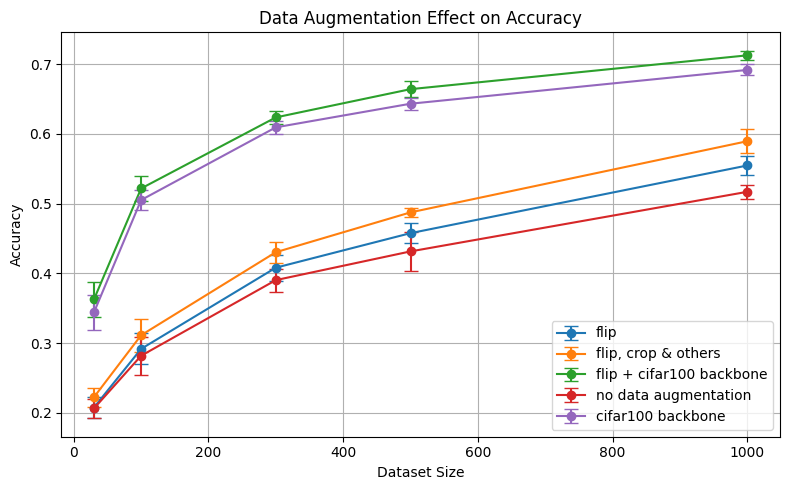

In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Configuration
augmentation_types = ["flip", "flip&crop&friends", "flipwCifar100", "project_base", "project_wCifar100"]          #["crop", "flip", "flip&crop", "project_base", "project_wCifar100", "project_wCifar100_freeze"]
dataset_sizes =  SUBSET_SIZES         #[100, 500, 1000]
base_filename = "results_data_augmentation_{}.{}.tmp_{}.txt"
labels = ["flip", "flip, crop & others", "flip + cifar100 backbone", "no data augmentation", "cifar100 backbone"]
# Storage
results = {}

cwd = os.getcwd()
print("Current working directory:", cwd)

# Load data
for aug in augmentation_types:
    means = []
    stds  = []
    sizes = []
    if aug == "project_base":
        base_filename = "results_{}.{}.tmp_{}.txt"
    # if aug == "project_wCifar100" or "project_wCifar100_freeze" :
    #     base_filename = "results_{}_{}.txt"
    for size in dataset_sizes:
        filename = base_filename.format(aug, size, size)
        if os.path.exists(filename):
            with open(filename, 'r') as f:
                values = np.array(list(map(float, f.read().strip().split())))
                means.append(np.mean(values))
                stds.append(np.std(values))
                sizes.append(size)
                print(f"fichier : {aug}, train data size : {size} --- Accuracy : {means[-1]:.3f} +- {stds[-1]:.3f}")
    results[aug] = (sizes, means, stds)

# Plotting
plt.figure(figsize=(8, 5))
for i, (aug, (sizes, means, stds)) in enumerate(results.items()):
    plt.errorbar(sizes, means, yerr=stds, label=labels[i], marker='o', capsize=5)

plt.xlabel("Dataset Size")
plt.ylabel("Accuracy")
plt.title("Data Augmentation Effect on Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("data_augm.pdf", format='pdf', bbox_inches='tight')
plt.show()